# Uni-Mol Molecular Property Prediction

**Licenses**

Copyright (c) DP Technology.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

**Citations**

Please cite the following papers if you use this notebook:

- Gengmo Zhou, Zhifeng Gao, Qiankun Ding, Hang Zheng, Hongteng Xu, Zhewei Wei, Linfeng Zhang, Guolin Ke. "[Uni-Mol: A Universal 3D Molecular Representation Learning Framework.](https://chemrxiv.org/engage/chemrxiv/article-details/6318b529bada388485bc8361)"
ChemRxiv (2022)

## Data Preparation (SMILES, label to .lmdb)

In [24]:
import os
import pickle
import lmdb
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool


# def smi2_2Dcoords(smi):
#     mol = Chem.MolFromSmiles(smi)
#     mol = AllChem.AddHs(mol)
#     AllChem.Compute2DCoords(mol)
#     coordinates = mol.GetConformer().GetPositions().astype(np.float32)
#     len(mol.GetAtoms()) == len(coordinates), "2D coordinates shape is not align with {}".format(smi)
#     return coordinates


# def smi2_3Dcoords(smi,cnt):
#     mol = Chem.MolFromSmiles(smi)
#     mol = AllChem.AddHs(mol)
#     coordinate_list=[]
#     for seed in range(cnt):
#         try:
#             res = AllChem.EmbedMolecule(mol, randomSeed=seed)  # will random generate conformer with seed equal to -1. else fixed random seed.
#             if res == 0:
#                 try:
#                     AllChem.MMFFOptimizeMolecule(mol)       # some conformer can not use MMFF optimize
#                     coordinates = mol.GetConformer().GetPositions()
#                 except:
#                     print("Failed to generate 3D, replace with 2D")
#                     coordinates = smi2_2Dcoords(smi)            
                    
#             elif res == -1:
#                 mol_tmp = Chem.MolFromSmiles(smi)
#                 AllChem.EmbedMolecule(mol_tmp, maxAttempts=5000, randomSeed=seed)
#                 mol_tmp = AllChem.AddHs(mol_tmp, addCoords=True)
#                 try:
#                     AllChem.MMFFOptimizeMolecule(mol_tmp)       # some conformer can not use MMFF optimize
#                     coordinates = mol_tmp.GetConformer().GetPositions()
#                 except:
#                     print("Failed to generate 3D, replace with 2D")
#                     coordinates = smi2_2Dcoords(smi) 
#         except:
#             print("Failed to generate 3D, replace with 2D")
#             coordinates = smi2_2Dcoords(smi) 

#         assert len(mol.GetAtoms()) == len(coordinates), "3D coordinates shape is not align with {}".format(smi)
#         coordinate_list.append(coordinates.astype(np.float32))
#     return coordinate_list


# def inner_smi2coords(content):
#     smi = content[0]
#     target = content[1:]
#     cnt = 10 # conformer num,all==11, 10 3d + 1 2d

#     mol = Chem.MolFromSmiles(smi)
#     if len(mol.GetAtoms()) > 400:
#         coordinate_list =  [smi2_2Dcoords(smi)] * (cnt+1)
#         print("atom num >400,use 2D coords",smi)
#     else:
#         coordinate_list = smi2_3Dcoords(smi,cnt)
#         coordinate_list.append(smi2_2Dcoords(smi).astype(np.float32))
#     mol = AllChem.AddHs(mol)
#     atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]  # after add H 
#     return pickle.dumps({'atoms': atoms, 
#     'coordinates': coordinate_list, 
#     'mol':mol,'smi': smi, 'target': target}, protocol=-1)


# def smi2coords(content):
#     try:
#         return inner_smi2coords(content)
#     except:
#         print("failed smiles: {}".format(content[0]))
#         return None


# def write_lmdb(inpath='./', outpath='./', nthreads=16):

#     df = pd.read_csv(os.path.join(inpath))
#     mol_col = "SMILE"
#     target_col = "RLU (log2)"
#     df = df[[mol_col, target_col]]
#     # sz = len(df)
#     # train, valid, test = df[:int(sz*0.8)], df[int(sz*0.8):int(sz*0.9)], df[int(sz*0.9):]
#     sz = 1920
#     train, valid, test = df[:int(sz*0.9)], df[int(sz*0.9):int(sz)], df[int(sz):]
#     for name, content_list in [('train.lmdb', zip(*[train[c].values.tolist() for c in train])),
#                                 ('valid.lmdb', zip(*[valid[c].values.tolist() for c in valid])),
#                                 ('test.lmdb', zip(*[test[c].values.tolist() for c in test]))]:
#         os.makedirs(outpath, exist_ok=True)
#         output_name = os.path.join(outpath, name)
#         try:
#             os.remove(output_name)
#         except:
#             pass
#         env_new = lmdb.open(
#             output_name,
#             subdir=False,
#             readonly=False,
#             lock=False,
#             readahead=False,
#             meminit=False,
#             max_readers=1,
#             map_size=int(100e9),
#         )
#         txn_write = env_new.begin(write=True)
#         with Pool(nthreads) as pool:
#             i = 0
#             for inner_output in tqdm(pool.imap(smi2coords, content_list)):
#                 if inner_output is not None:
#                     txn_write.put(f'{i}'.encode("ascii"), inner_output)
#                     i += 1
#             print('{} process {} lines'.format(name, i))
#             txn_write.commit()
#             env_new.close()

# write_lmdb(inpath='4CR-1920.csv', outpath='./4CR', nthreads=8)

## Finetuning (based on pretraining)

In [2]:
data_path='./'  # replace to your data path
save_dir='./save_4CR'  # replace to your save path
MASTER_PORT=10086
n_gpu=1
dict_name='dict.txt'
weight_path='./weights/mol_pre_no_h_220816.pt'  # replace to your ckpt path
task_name='4CR'  # data folder name
task_num=1
loss_func='finetune_mse'
lr=1e-4
batch_size=64
epoch=60
dropout=0.1
warmup=0.06
local_batch_size=64
only_polar=0 # -1 all h; 0 no h
conf_size=11
seed=0
metric="valid_agg_rmse"
update_freq=batch_size / local_batch_size

# !python -m torch.distributed.launch --nproc_per_node=$n_gpu --master_port=$MASTER_PORT $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \

!cp ../example_data/molecule/$dict_name $data_path
!export NCCL_ASYNC_ERROR_HANDLING=1
!export OMP_NUM_THREADS=1
!python $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \
       --conf-size $conf_size \
       --num-workers 6 --ddp-backend=c10d \
       --dict-name $dict_name \
       --task mol_finetune --loss $loss_func --arch unimol_base  \
       --classification-head-name $task_name --num-classes $task_num \
       --optimizer adam --adam-betas '(0.9, 0.99)' --adam-eps 1e-6 --clip-norm 1.0 \
       --lr-scheduler polynomial_decay --lr $lr --warmup-ratio $warmup --max-epoch $epoch --batch-size $local_batch_size --pooler-dropout $dropout\
       --update-freq $update_freq --seed $seed \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 100 --log-format simple \
       --validate-interval 1 --keep-last-epochs 10 \
       --finetune-from-model $weight_path \
       --best-checkpoint-metric $metric --patience 20 \
       --save-dir $save_dir --only-polar $only_polar \
       # --maximize-best-checkpoint-metric
# --maximize-best-checkpoint-metric, for classification task

2023-12-07 15:35:10 | INFO | unicore_cli.train | Namespace(activation_dropout=0.0, activation_fn='gelu', adam_betas='(0.9, 0.99)', adam_eps=1e-06, all_gather_list_size=16384, allreduce_fp32_grad=False, arch='unimol_base', attention_dropout=0.1, batch_size=64, batch_size_valid=64, best_checkpoint_metric='valid_agg_rmse', bf16=False, bf16_sr=False, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_suffix='', classification_head_name='4CR', clip_norm=1.0, conf_size=11, cpu=False, curriculum=0, data='./', data_buffer_size=10, ddp_backend='c10d', delta_pair_repr_norm_loss=-1.0, device_id=0, dict_name='dict.txt', disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_num_procs=1, distributed_port=-1, distributed_rank=0, distributed_world_size=1, dropout=0.1, ema_decay=-1.0, emb_dropout=0.1, empty_cache_freq=0, encoder_attention_heads=64, encoder_embed_dim=512, encoder_ffn_embed_dim=2048, encoder_layers=15, end_learning_

## Inference

In [16]:
data_path='./'  # replace to your data path
results_path='./infer_4CR'  # replace to your results path
weight_path='./save_4CR/checkpoint_best.pt'  # replace to your ckpt path
# batch_size=64
# task_name='4CR' # data folder name 
# task_num=1
# loss_func='finetune_mse'
# dict_name='dict.txt'
# conf_size=11
# only_polar=0

!cp ../example_data/molecule/$dict_name $data_path
!CUDA_VISIBLE_DEVICES="0" python ../unimol/infer.py --user-dir ../unimol $data_path --task-name $task_name --valid-subset valid \
       --results-path $results_path \
       --num-workers 6 --ddp-backend=c10d --batch-size $batch_size \
       --task mol_finetune --loss $loss_func --arch unimol_base \
       --classification-head-name $task_name --num-classes $task_num \
       --dict-name $dict_name --conf-size $conf_size \
       --only-polar $only_polar  \
       --path $weight_path  \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 50 --log-format simple 

2023-12-07 15:50:20 | INFO | unimol.inference | loading model(s) from ./save_4CR/checkpoint_best.pt
2023-12-07 15:50:21 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2023-12-07 15:50:23 | INFO | unimol.inference | Namespace(activation_dropout=0.0, activation_fn='gelu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, all_gather_list_size=16384, allreduce_fp32_grad=False, arch='unimol_base', attention_dropout=0.1, batch_size=64, batch_size_valid=64, bf16=False, bf16_sr=False, broadcast_buffers=False, bucket_cap_mb=25, classification_head_name='4CR', conf_size=11, cpu=False, curriculum=0, data='./', data_buffer_size=10, ddp_backend='c10d', delta_pair_repr_norm_loss=-1.0, device_id=0, dict_name='dict.txt', disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_num_procs=1, distributed_port=-1, distributed_rank=0, distributed_world_size=1, dropout=0.1, ema_decay=-1.0, emb_dropout=0.1, empty_cache_freq=0, encoder_

## Read inference results (.pkl to .csv)

In [17]:

def get_csv_results(predict_path, csv_path):
    predict = pd.read_pickle(predict_path)
    smi_list, predict_list = [], []
    target_list = []
    for batch in predict:
        sz = batch["bsz"]
        for i in range(sz):
            smi_list.append(batch["smi_name"][i])
            predict_list.append(batch["predict"][i][0].cpu().tolist())
            target_list.append(batch["target"][i][0].cpu().tolist())
    predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list, "target": target_list})
    predict_df = predict_df.groupby("SMILES").mean().reset_index()
    predict_df.to_csv(csv_path,index=False)
    return predict_df

predict_path='./infer_4CR/save_4CR_test.out.pkl'  # replace to your results path
csv_path='./infer_4CR/4CR_results.csv'
predict_df = get_csv_results(predict_path, csv_path)
predict_df.info(), predict_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   576 non-null    object 
 1   predict  576 non-null    float64
 2   target   576 non-null    float64
dtypes: float64(2), object(1)
memory usage: 13.6+ KB


(None,
                                               SMILES    predict  target
 0  CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...   4.300959     0.1
 1  CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...   7.346236     0.1
 2  CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...   7.219815     0.1
 3  CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...  10.436080     0.1
 4  CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...   4.086115     0.1)

In [18]:
predict_df

,SMILES,predict,target
0,CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...,4.300959,0.1
1,CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...,7.346236,0.1
2,CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...,7.219815,0.1
3,CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...,10.436080,0.1
4,CCCCCCCCC(CCCCCC)C(=O)N(C(CCCCCCC\C=C/C\C=C/CC...,4.086115,0.1
...,...,...,...
571,CCCCC\C=C/C\C=C/CCCCCCCC(N(CCN1CCNCC1)C(=O)CCC...,5.405895,0.1
572,CCCCC\C=C/C\C=C/CCCCCCCC(N(CCN1CCNCC1)C(=O)CCC...,6.239347,0.1
573,CCCCC\C=C/C\C=C/CCCCCCCC(N(CCN1CCNCC1)C(=O)CCC...,8.687855,0.1
574,CCCCC\C=C/C\C=C/CCCCCCCC(N(CCN1CCNCC1)C(=O)CCC...,5.845526,0.1


In [19]:
# compute the pearson correlation coefficient between predict and target
from scipy.stats import pearsonr
pearson_corr = pearsonr(predict_df["predict"], predict_df["target"])[0]
print("pearsonr: ", pearson_corr)

pearsonr:  nan


Top 10 predicted smiles: 


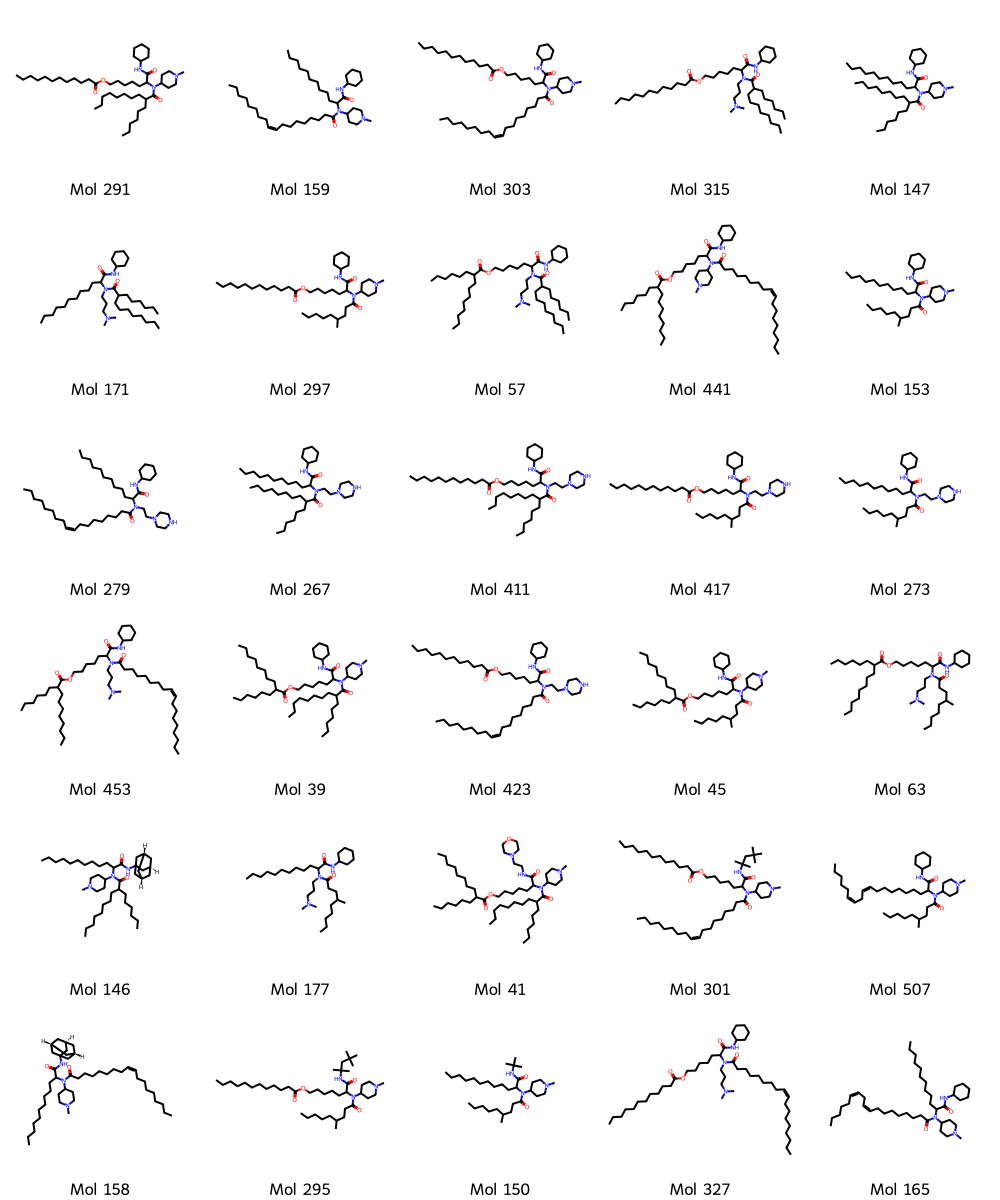

['CCCCCCCCCCCC(=O)OCCCCCC(N(C1CCN(C)CC1)C(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCC(N(C1CCN(C)CC1)C(=O)CCCCCCC\\C=C/CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCCC(=O)OCCCCCC(N(C1CCN(C)CC1)C(=O)CCCCCCC\\C=C/CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCCC(=O)OCCCCCC(N(CCCN(C)C)C(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCC(N(C1CCN(C)CC1)C(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCC(N(CCCN(C)C)C(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCCC(=O)OCCCCCC(N(C1CCN(C)CC1)C(=O)CCC(C)CCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(N(CCCN(C)C)C(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCC\\C=C/CCCCCCCC(=O)N(C(CCCCCOC(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1)C1CCN(C)CC1'
 'CCCCCCCCCCC(N(C1CCN(C)CC1)C(=O)CCC(C)CCCCC)C(=O)NC1CCCCC1']


In [28]:
# rank the predict_df by predict value
predict_df_sort = predict_df.sort_values(by="predict", ascending=False)
predict_df_sort.to_csv("./infer_4CR/4CR_results_sort.csv", index=False)

# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[:30]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[:30]])
display(img)
print(predict_df_sort["SMILES"].values[:10])

Least 10 predicted smiles: 


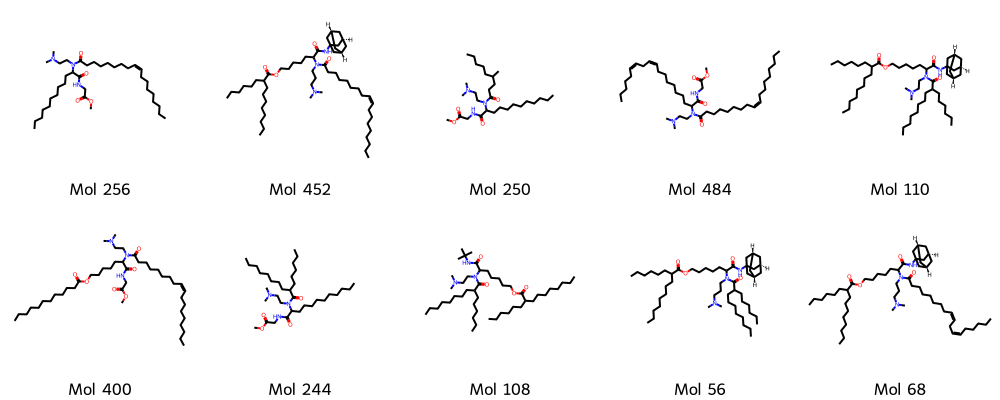

In [21]:
print("Least 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[-10:]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[-10:]])
display(img)

Top 10 experiment smiles: 


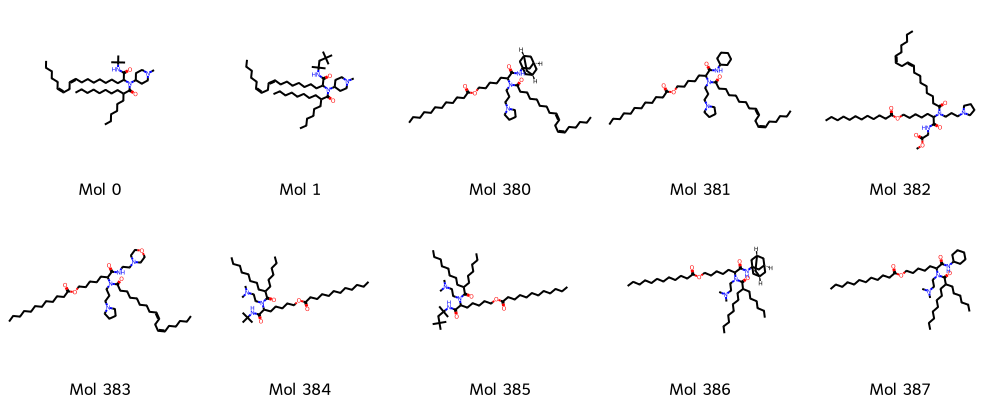

In [22]:
# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 experiment smiles: ")
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df.sort_values(by="target", ascending=False)["SMILES"].values[:10]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df.sort_values(by="target", ascending=False)["SMILES"].index[:10]])